Importando o banco de dados MNIST
-------

In [1]:
import numpy as np

In [2]:
%%time
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

CPU times: user 29.9 s, sys: 815 ms, total: 30.7 s
Wall time: 45.8 s


In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Pegando o vetor da característica de uma instância, remodelá-lo em uma array 28 x 28 e exibi-lo usando a função "imshow()"

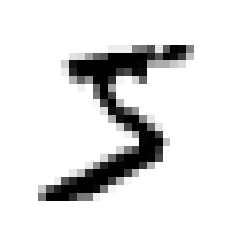

CPU times: user 63.2 ms, sys: 4.01 ms, total: 67.2 ms
Wall time: 80.1 ms


In [5]:
%%time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

-----
* Resolvendo problemas


Função para conseguir plotar as imagens do banco de dados e as matrizes de entrada tenso o mesmo numero de dimensões:

In [103]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Aqui, a função é feita para conseguir plota as imagens do banco de dados na etapa de Anális de Erro com as dimensões corretas para funcionar perfeitamente:

* ***Obs: essas duas funções foi colocada ao pesquisar sobre os erros que foi aparecendo durante o projeto e com a ajuda de membros do Github e do stackoverflow.***

In [93]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    
    images_per_row = min(len(instances), images_per_row)

    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

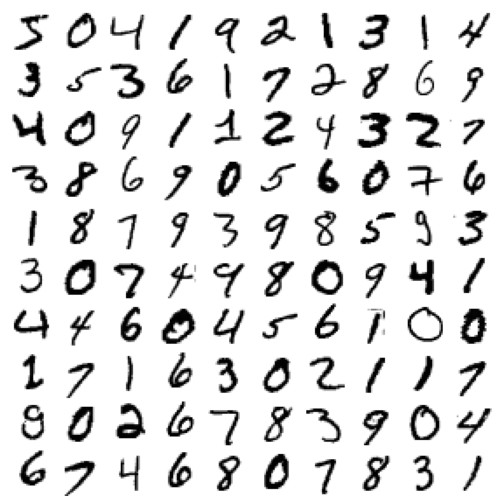

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

-------

Convertendo Y para inteiro.

In [9]:
y = y.astype(np.uint8)

* Criando um conjunto de teste e seprando antes de especionar os dados:

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[:60000]

Treinando um Classificador Binário.
---------------------------





In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Usando o Classificador SGDClassifier - Gradiente Descendente estocástico - da Scikit-Learn.


* O SGDClassifier depende da aleatoriedade durante o treinamento.
* Os parâmetros do random_state podem ser difinidos para ter resultados que possam ser reproduzidos.


In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

Cáculo de Desempenho.
---------------------



Calculando a acurácia com a validação cruzada:

.Implementando a Validação Cruzada

In [14]:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


Avaliando o modelo SGDClassifier com a função cross_val_score() com o metodo do K-fold:



*   Aqui acurácia foi acima de 93%, informando que a proporção de predições é correta.






In [15]:

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

------------------------------------------
- Um classificar que deixa a desejar (para fins didaticos).

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)    

Estimando a acurácia desse modelo:

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

uma demostração do por que geralmente a acurácia não é a medida de desempenho preferida para os classificadores, sobre tudo quando você estiver enfrentando um banco de dados assimêtricos.

-----------------------------

Matrix de Confusão
-----------

Pode-se realizar predições sobre o conjunto de testes, mas será feito em outro momento, enquanto isso será usado a função cross_val_predict(), assim: 


*   Realizando o método K-fold de validação cruzada com a função cross_val_predict(), ela retorna as predições feitas em cada teste de fold.

* Significa que você terá uma predição "limpa" (quando uma predição é feita por um modelo que nunca manipulou os dados durante o treinamento).



In [18]:
%%time
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)



CPU times: user 35.3 s, sys: 243 ms, total: 35.5 s
Wall time: 35 s


Agora, obtendo a matriz de confusão usando a função confusion_matrix() passando as classes-alvo y_train_5 e as classes previstas y_train_pred.

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* Na primeira linha desta matriz considera imagens não-5 (classe negativa): 53892 delas foram classificadas corretamente como não-5 (o famoso verdadeiros negativos), já as 687 restantes foram falsos positivos.

* Na segunda linha considera as imagens dos 5s (classe positiva): 1891 foram classificados como falso negativo, o restante dos 3530 foram classificados perfeitamente como verdadeiros positivos.

-Lembrando que um classificador perfeito teria somente verdadeiros positivos e verdadeiros negativos, no caso a sua matriz de confusão teria valores diferentes de zera apenas em sua diagonal principal, como segue no exemplo abaixo:

In [20]:
y_train_perfect_predition = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predition)

array([[54579,     0],
       [    0,  5421]])

Precisão e Renovação 
--------

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (3530+687)

0.8370879772350012

* 83,70%

In [22]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (3530+1891)

0.6511713705958311

* 65,11%

Acima mostra que o detector não parece tão bom como quando foi analisado anteriormente. 



*   Calculando o F1 score com a função f1_score:



In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 73,25%

Trade-off precisão/revocação
------

chamando o metodo decision_function(), onde retorna um score para cada instância e, em seguida faz as predições com base nesses scores usando qualquer linha limiar desejad:

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0

In [26]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Aumentando o limiar do SGDClassifier:

In [27]:
threshold = 8000

In [28]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Ao aumentar o limiar, diminui a revocação. o Classificador detecta quando o limiar é 0, mas o perde quando o limiar sobe até 8 mil.

* Agora sera usado a função cross_val_predict() para obter os scores de todas as instâncias no conjunto de treinamento.

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

* Calculando a precisão e a revocação de todos os limiares possiveis com a função precision_recall_curve:

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

* Plotando um grafico mostrando a precisão e a revocação:

Um detalhe, o codigo do livro estava errado, aqui em baixo segue a versão corrigida.

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

In [32]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = threshold[np.argmax(precisions >= 0.90)]

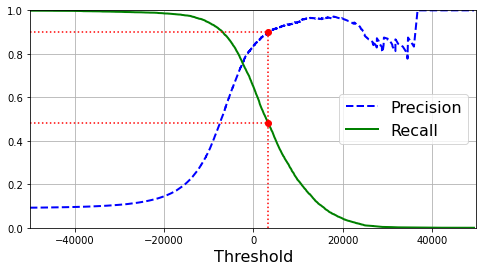

In [33]:
plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                      
plt.show()

In [34]:
(y_train_pred == (y_scores > 0)).all()

True

* Plotando um grafico com a precisão diretamente em relação á revocação:

In [35]:
def plot_precision_recall(precision, recalls):
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("Revocação", fontsize=13)
  plt.ylabel("Precisão", fontsize=13)
  plt.axis([0, 1, 0, 1])
  plt.grid(True)


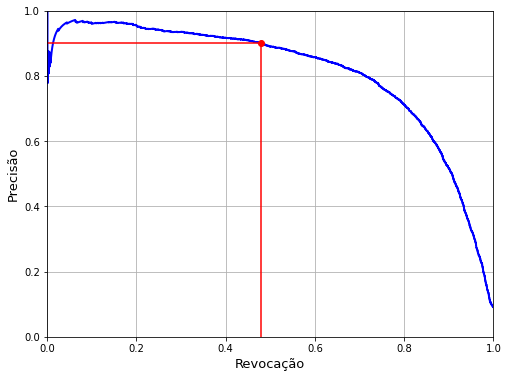

In [36]:
plt.figure(figsize=(8, 6))
plot_precision_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.,0.9], "r")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()  

* Procurando o limiar mais baixo que forneça pelo menos 90% de precisão usando o
np.argmax().

In [37]:
threshold_90_precision = threshold[np.argmax(precisions >= 0.90)]

* Para fazer predições em vez de chamar o metodo predict(), estou usando esse códico abaixo:

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

* conferindo a precisão e a revocação dessas predições

att. isso mostra que tenho um classificador com 90%!

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

 *Curva* ROC
---

* Antes de plotar a curva ROC, irie usar a função roc_curve() a fim de calcular a TPR e o FPR para varios valores de limiares.

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

* Agora uma função para plota FPR em relação ao TPR usando o matplotlib (por enquanto rsrs)

In [42]:
from sklearn.metrics._plot.roc_curve import plot_roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                
    plt.xlabel('Taxa de falsos positivos (Fall-Out)', fontsize=16)
    plt.ylabel('Taxa de Verdadeiro Positivo (Recall)', fontsize=16)
    plt.grid(True)     

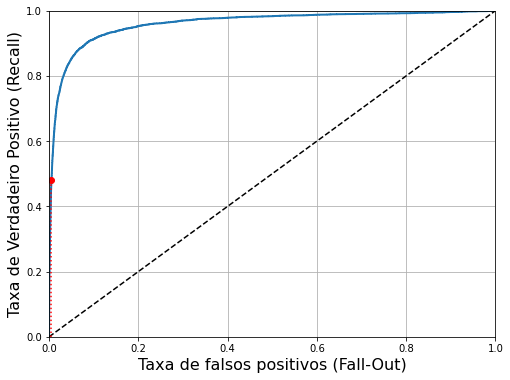

In [43]:
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                                   
plt.show()

* Calculando o ROC AUC:

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* Treinando um RandomForestClassifier e comparar o SGDClassifier.

In [45]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

CPU times: user 1min 23s, sys: 265 ms, total: 1min 24s
Wall time: 1min 23s


* Usando a probabilidade da classe positiva como a score:

In [46]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

* Plotando a Curva ROC do RandomForestClassifier:

In [47]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

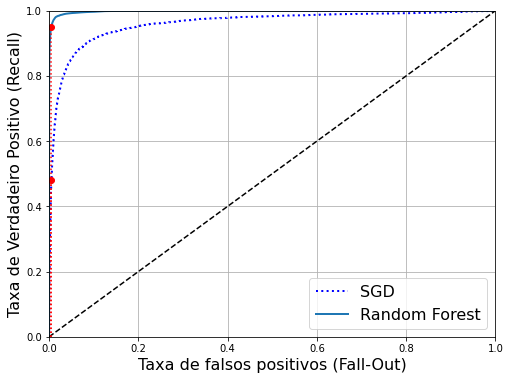

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

* A curva ROC do RandomForestClassifier se demonstrou melhor que a do SGDClassifier, ficando mais proximo de 1.

* Mostrando logo em seguida o valor do score:

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- o valor do score foi de 99,83%, assim podemos dizer que foi quase perfeito o seu desempenho 😯. 

Classificação Multiclasse
----

Para iniciar essa etapa, eu irei usar o algoritimo SVC (Support Vector Classification):

* Esse código treina o svc no conjunto de treinamento usando as classes alvos originais de 0 a 9 (y_rain) em vez das classes alvos 5 versus the rest (y_train_5):


**Atenção: O código abaixo demorou mais de 2 horas para ser executado, por isso foi colocar "X_train[:1000], y_train[:1000]", para limitar a leitura apenas para as primeiras 1000 linhas.**

**Motivo: não tenho um hardware potente para ler esse banco de dados, mesmo ele sendo bem básico.**



In [50]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* Logo abaixo é usado o decision_function para retorna 10 scores por instâncias, sendo um score por classe:

Nota importante de aprendizado: Quando um classificador é treinado, ele armazena a lista de classes alvos no atributo classes_, ordenado por valor.

Abaixo eu faço uma visualização do índice de cada classe:

In [51]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [52]:
np.argmax(some_digit_scores)

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [54]:
svm_clf.classes_[5]

5

-----------

Para fins didaticos, o scikit-Learn será forçado a usar a estratégia "one versus one" ou "one versus the rest" com as classes OneVsOneClassifier ou OneVsRestClassifier:

ps: cuidado, esses códigos pode demora minutos ou até horas para rodar dependendo do seu hardwae.

In [55]:
from  sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

45



---



Classificando diretamente as instâncias em várias classes com o SGD.

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

* O mesmo que anteriormente, a função decision_function() retorna um valor por classe, assim podendo visualizar o score que o classificador SGD atribuiu a cada classe:

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

* Avaliando o classificador SGD, usando a validação cruzada com a função cross_val_score() para avaliar a accuracy:

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

* Aqui o score foi de 87,36%, porem ainda ainda tem como melhorar.

* Fazendo o escalonamento das entradas para aumentar a acurácia acima de 89%, ou ao menos tentar:

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

* O score ficou entorno de 89,83%.

# Análise de Erro

Analisando a Matriz de confusão:

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

* Plotando o grafico para melhor visualização:

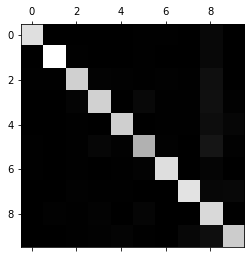

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

-------
* **apenas plotando um gráfico interativo da mtrix de confusão para melhor entendimento da explicação que vem a seguir**

In [63]:
import plotly.express as px

fig = px.imshow(conf_mx, text_auto=True)
fig.show()

------

* Representação dos erros, dividindo cada valor da matrix de confusão pelo número de imagens na classe correspondente de modo que consiga comparar as taxas de erros, em vez números absolutos de erros:

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

* Agora preenchendo a diagonal com zeros para manter os erros e mostrar os resultados:

> Aqui serve para olhar de forma clara os tipos de erros que o classificador comete.






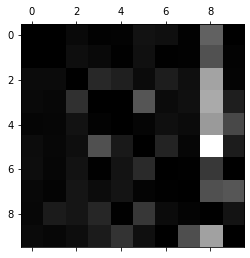

In [65]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* Visualizando os valores em um grafico interativo:

In [66]:
fig = px.imshow(norm_conf_mx, text_auto=True)
fig.show()

* Plotando os exemplos 3 e 5, onde mostrado no plot anterior, é onde geralmente fica confuso no classificador (não é classificado de forma correta e o classificador fica confuso ao identificar as imagens):

Nota: como 3 e 5 se diferem apenas em alguns pixels, esse modelo facilmente se confunde, o motivo é por conta do uso do SGDClassifier simples, que é um modelo linear. 

* **Se você desenhar um 3 com a junção levemente deslocada á esquerda, o classificador poderá classificá-lo como 5 e por ai vai.**

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


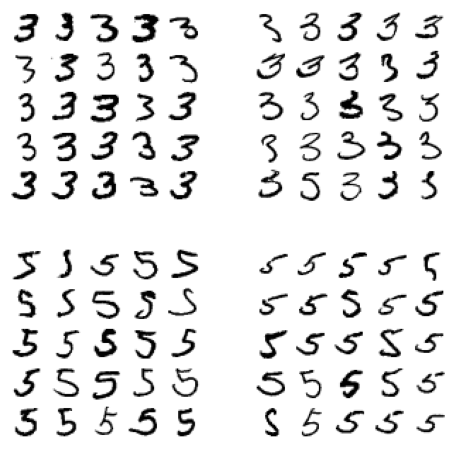

In [68]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* Para poder ajudar a resolver problemas como esse, é pré-processando as imagens para assegurar que estejam bem centralizadas, assim envitando confusões em um classificador simples que funciona de forma linear.

# Classificação Multirrótulo

Criando uma array y_multilabel contendo dois rótulos=-alvos para cada imagem de algarismo:

* O primeiro indica se o algarismo é maior ou igual a 7, ou não.
* O segundo é ímpar ou não.


In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Em seguida, a criação de uma instância KneighborsClassifier e trainando usando o array para múltiplos alvos:

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

* Aqui mostra que o Algarismo 5 não é grande, e sim ímpar.

Contabilizando o F1 score em todos os rótulos:

In [76]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

* Valor do F1 score, entorno de 0,9764.

* Atribuindo a cada rótulo um peso igual ao seu support com o "weighted".

In [77]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

* Mostra uma pequena alta no F1 score, para o valor de 0,9778.

# Classificação Multioutput

Criando um sistema que remove o ruído das imagens:

- A saida do classificador é muiltrrotulada e cada rótulo pode ter vários valores.

* Criando um conjunto de treinamento e teste, usando as imagens do MNIST e adicionando ruído ás suas intensidades de pixel com a função randint():

* As imagens alvos é as imagens originais.

In [78]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

* Dando uma olhada em uma imgem do conjunto de testes:

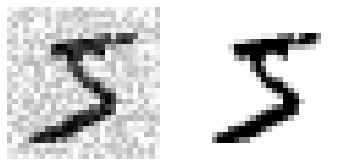

In [105]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

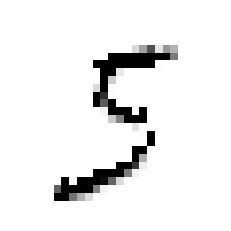

In [104]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Parece ser algo bem proximo da imagem alvo, assim finalizando o processo de estudo e pratica da aplicação de classificação com o banco de dados MNIST.

--------

# Trabalho concluido!